In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

base = "/content/drive/MyDrive/f1_data/"

drivers = pd.read_csv(base + "drivers.csv")
races = pd.read_csv(base + "races.csv")
lap_times = pd.read_csv(base + "lap_times.csv")

drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [4]:
races_modern = races[(races['year'] >= 2014) & (races['year'] <= 2024)]
race_ids_modern = races_modern['raceId'].unique()

lap_times_modern = lap_times[lap_times['raceId'].isin(race_ids_modern)]
group_sizes = lap_times_modern.groupby(['raceId', 'driverId'])['lap'].count()

In [5]:
#Create windows of length 10 for one driver for one race

sequence_length = 10

def create_windows(lap_times_array, seq_len):

  X = []
  y = []

  for i in range(len(lap_times_array) - seq_len):

    window = lap_times_array[i:i + seq_len]
    target = lap_times_array[i + seq_len]

    X.append(window)
    y.append(target)

  return X, y

In [6]:
#Sort and group lap times by raceId and driverId
lap_times_sorted = lap_times_modern.sort_values(['raceId', 'driverId', 'lap'])
grouped = lap_times_sorted.groupby(['raceId', 'driverId'])

#Lists to hold all windows across all drivers and races as well as to hold targets
X_list = []
y_list = []

for (race_id, driver_id), group in grouped:

  #Get the current drivers lap times for the current race
  times = group['milliseconds'].values

  #Skip groups that are too short to create windows
  if len(times) <= sequence_length:
    continue

  #Call create_windows to create a window for the current driver+race
  X_g, y_g = create_windows(times, sequence_length)

  #Add this window to the comprehensive window list
  X_list.extend(X_g)
  y_list.extend(y_g)

len(X_list), len(y_list), X_list[0][:5], y_list[0]

(204145,
 204145,
 array([102038,  97687,  95765,  94939,  95438]),
 np.int64(95185))

In [7]:
X = np.array(X_list, dtype=np.float32)
y = np.array(y_list, dtype=np.float32)

#Reshape to make 3D using feature count to be compatible for LSTMs
num_samples, seq_len = X.shape
X = X.reshape((num_samples, seq_len, 1))

In [8]:
#Split data into train, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

X_train.shape, X_temp.shape, y_train.shape, y_temp.shape

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    shuffle=True
)



In [9]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()

num_train, seq_len, num_features = X_train.shape
X_train_flat = X_train.reshape(-1, num_features)

#Normalize lap times for training set
X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(num_train, seq_len, num_features)
X_train_scaled.shape, X_train.shape

#Normalize lap times for validation set
num_val = X_val.shape[0]
X_val_flat = X_val.reshape(-1, num_features)
X_val_scaled_flat = scaler_X.transform(X_val_flat)
X_val_scaled = X_val_scaled_flat.reshape(num_val, seq_len, num_features)

#Normalize lap times for test set
num_test = X_test.shape[0]
X_test_flat = X_test.reshape(-1, num_features)
X_test_scaled_flat = scaler_X.transform(X_test_flat)
X_test_scaled = X_test_scaled_flat.reshape(num_test, seq_len, num_features)

In [10]:
#Scale targets (y)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [11]:
#Create model
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
  layers.LSTM(64, return_sequences=False, input_shape=(seq_len, num_features)),
  layers.Dropout(0.2),
  layers.Dense(32, activation='relu'),
  layers.Dense(1)
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#Compile and train model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=20,
    batch_size=64
)

Epoch 1/20
2233/2233 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - loss: 0.9586 - mean_absolute_error: 0.1368 - val_loss: 0.7622 - val_mean_absolute_error: 0.0974
Epoch 2/20
2233/2233 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6554 - mean_absolute_error: 0.1185 - val_loss: 0.7062 - val_mean_absolute_error: 0.0922
Epoch 3/20
2233/2233 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.7555 - mean_absolute_error: 0.1350 - val_loss: 0.7081 - val_mean_absolute_error: 0.2491
Epoch 4/20
2233/2233 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6998 - mean_absolute_error: 0.1278 - val_loss: 0.6519 - val_mean_absolute_error: 0.1327
Epoch 5/20
2233/2233 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.8105 - mean_absolute_error: 0.1313 - val_loss: 0.5502 - val_mean_absolute_error: 0.0829
Epoch 6/20
2233/2233 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6228 - mean_absolute_error: 0.1209 - val_loss: 0.5123 - val_mean_absolute_error: 0.0959
Epoch 7/20
2233/2233 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.6364 - mean_a

In [13]:
preds = model.predict(X_test_scaled)

957/957 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [14]:
y_pred_scaled = preds.flatten()
y_pred_ms = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_ms = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

y_pred_ms[:5], y_test_ms[:5]

(array([102836.22 ,  86931.805,  85484.055,  88071.83 ,  67330.484],
       dtype=float32),
 array([101677.,  82046., 112793.,  85405.,  68019.], dtype=float32))

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_ms2 = mean_squared_error(y_test_ms, y_pred_ms)
mae_ms = mean_absolute_error(y_test_ms, y_pred_ms)
rmse_ms = np.sqrt(mse_ms2)


print("Test MAE (ms):", mae_ms)
print("Test RMSE (ms):", rmse_ms)
print("Test MAE (seconds):", mae_ms / 1000.0)
print("Test RMSE (seconds):", rmse_ms / 1000.0)

Test MAE (ms): 5454.076171875
Test RMSE (ms): 43025.76865089106
Test MAE (seconds): 5.454076171875
Test RMSE (seconds): 43.02576865089106


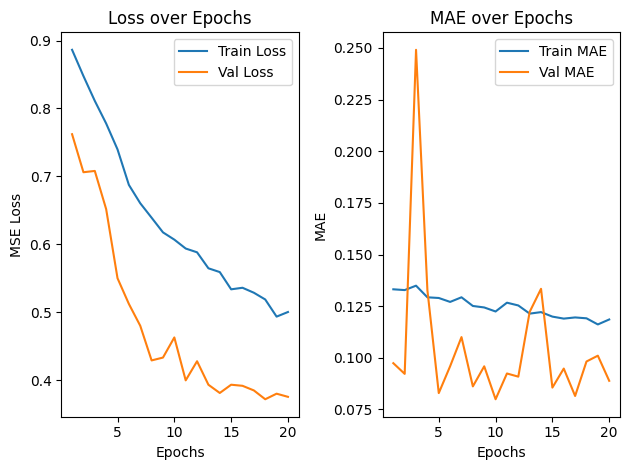

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_mae = history_dict['mean_absolute_error']
val_mae = history_dict['val_mean_absolute_error']

epochs = range(1, len(train_loss) + 1)

#Loss vs Epochs plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

#MAAE vs Epochs plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_mae, label='Train MAE')
plt.plot(epochs, val_mae, label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

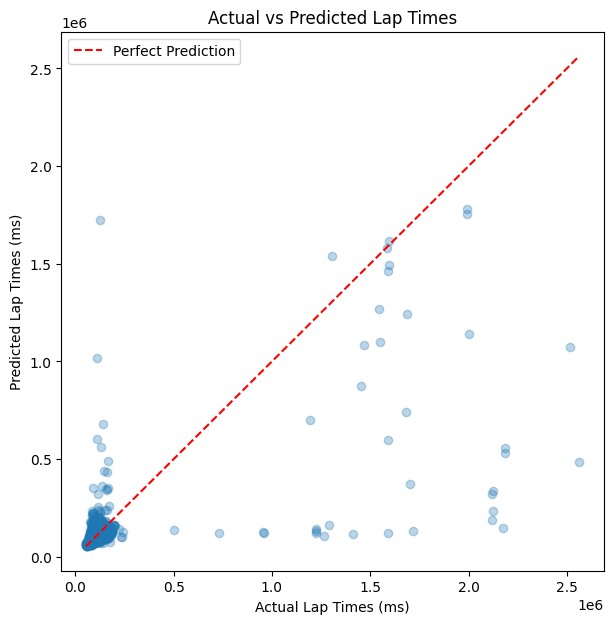

In [18]:
#Actual vs Predicted Scatter

plt.figure(figsize=(7,7))

plt.scatter(y_test_ms, y_pred_ms, alpha=0.3)
min_val = min(y_test_ms.min(), y_pred_ms.min())
max_val = max(y_test_ms.max(), y_pred_ms.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.title('Actual vs Predicted Lap Times')
plt.xlabel('Actual Lap Times (ms)')
plt.ylabel('Predicted Lap Times (ms)')
plt.legend()
plt.show()

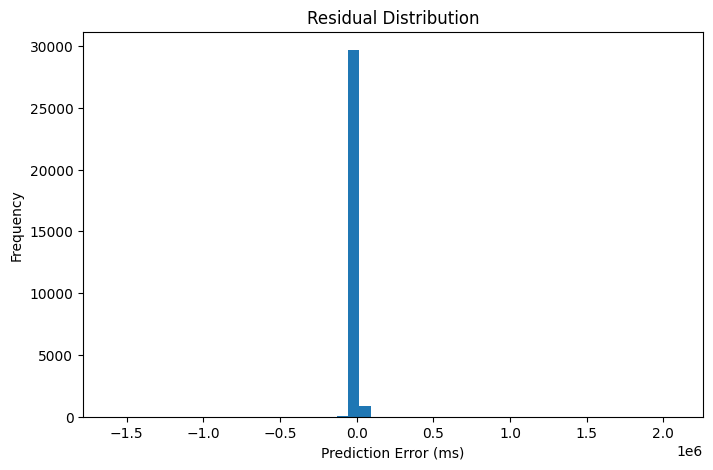

Mean Error (ms): 256.62128
Std of error (ms): 43025.008


In [21]:
#Residual Distribution (Prediction Error)

errors_ms = y_test_ms - y_pred_ms

plt.figure(figsize=(8,5))
plt.hist(errors_ms, bins=50)
plt.title('Residual Distribution')
plt.xlabel('Prediction Error (ms)')
plt.ylabel('Frequency')
plt.show()

print("Mean Error (ms):", np.mean(errors_ms))
print("Std of error (ms):", np.std(errors_ms))

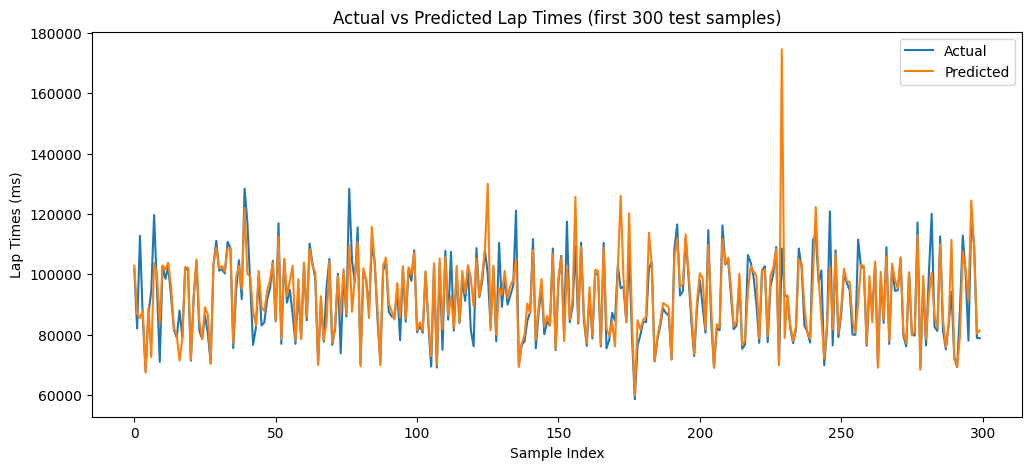

In [23]:
#Sample Sequence
sample_len = 300
plt.figure(figsize=(12,5))

plt.plot(y_test_ms[:sample_len], label='Actual')
plt.plot(y_pred_ms[:sample_len], label='Predicted')

plt.title(f'Actual vs Predicted Lap Times (first {sample_len} test samples)')
plt.xlabel('Sample Index')
plt.ylabel('Lap Times (ms)')
plt.legend()
plt.show()